In [1]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

Downloaded 23708 samples.


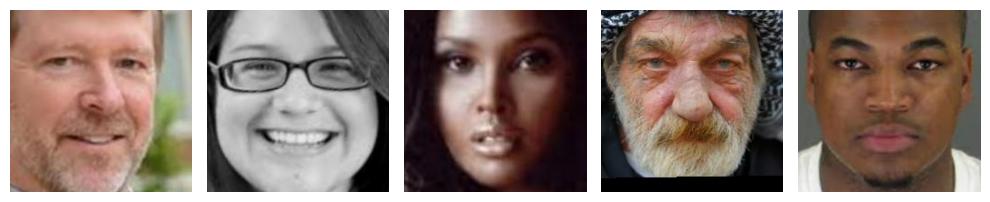

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

data_dir = Path('UTKFace')
images = list(data_dir.glob('*.jpg'))

print(f"Downloaded {len(images)} samples.")

# Display a few images
plt.figure(figsize=(10, 5))
for i in range(min(5, len(images))):
    img_path = images[i]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Initial dataset: 23708 samples
Cleaned dataset: 23315 samples


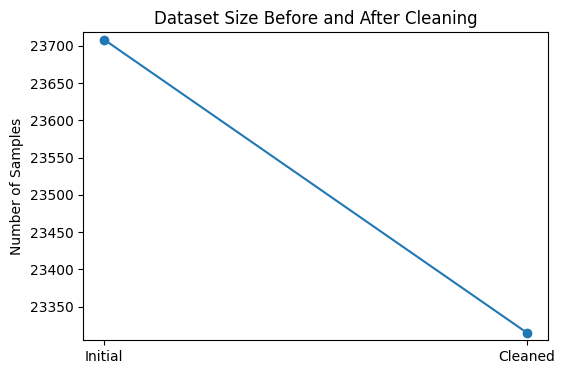

In [3]:
import os
import cv2
import hashlib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

data_dir = Path('UTKFace')
images = list(data_dir.glob('*.jpg'))

initial_count = len(images)
print(f"Initial dataset: {initial_count} samples")


# Parse labels from filenames
def parse_filename(filename):
    parts = filename.stem.split('_')
    if len(parts) >= 3 and parts[0].isdigit() and parts[1].isdigit() and parts[2].isdigit():
        return int(parts[0]), int(parts[1]), int(parts[2])  # age, gender, race
    return None

parsed_data = []
duplicates = set()
for img_path in images:
    label = parse_filename(img_path)
    if label is None:
        # Optionally, you could log or print the filenames that are skipped
        # print(f"Skipping file with invalid format: {img_path}")
        continue

    # Check corruption
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            img_path.unlink()
            continue
    except:
        img_path.unlink()
        continue

    # Check duplicate (simple hash)
    try:
        img_hash = hashlib.md5(open(str(img_path), 'rb').read()).hexdigest()
        if img_hash in duplicates:
            img_path.unlink()
            continue
        duplicates.add(img_hash)
    except:
        # Handle cases where file reading for hashing might fail
        img_path.unlink()
        continue


    parsed_data.append({'path': str(img_path), 'age': label[0], 'gender': label[1], 'race': label[2]})

df = pd.DataFrame(parsed_data)
cleaned_count = len(df)
print(f"Cleaned dataset: {cleaned_count} samples")
df.to_csv('utkface_cleaned.csv', index=False)  # Save metadata

# Plot the difference
labels = ['Initial', 'Cleaned']
counts = [initial_count, cleaned_count]

plt.figure(figsize=(6, 4))
plt.plot(labels, counts, marker='o', linestyle='-') # Use plot for line graph
plt.ylabel('Number of Samples')
plt.title('Dataset Size Before and After Cleaning')
plt.ylim(min(counts) - 10, max(counts) + 10) # Adjust y-axis limits to show difference
plt.show()

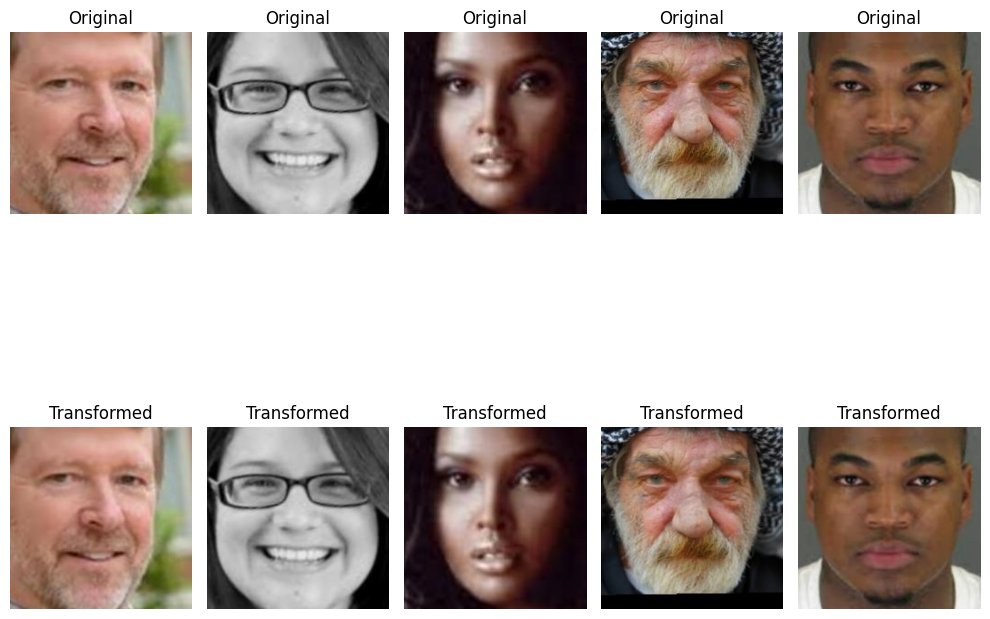

Preprocessed sample: Shape torch.Size([3, 256, 256])


In [4]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # To [-1,1]
])

# Display a few images before and after transform
plt.figure(figsize=(10, 10))
for i in range(min(5, len(df))):
    row = df.iloc[i]
    img_path = row['path']
    img = Image.open(img_path).convert('RGB')

    # Display original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    # Apply transform and display transformed image
    tensor = transform(img)
    # Convert tensor back to numpy array for displaying with matplotlib
    img_transformed = tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5 # Denormalize for display
    plt.subplot(2, 5, i + 6)
    plt.imshow(img_transformed)
    plt.title("Transformed")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Apply transform to dataset (example on first 100 for demo)
preprocessed = []
for _, row in df.head(100).iterrows():
    img = Image.open(row['path']).convert('RGB')
    tensor = transform(img)
    preprocessed.append({'tensor': tensor, 'age': row['age'], 'bin': 'young' if row['age'] <= 25 else 'middle' if row['age'] <= 50 else 'old'})

print(f"Preprocessed sample: Shape {preprocessed[0]['tensor'].shape}")

In [5]:
from sklearn.model_selection import train_test_split

df['bin'] = df['age'].apply(lambda x: 'young' if x <= 25 else 'middle' if x <= 50 else 'old')

train_val, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df['bin'])
train, val = train_test_split(train_val, test_size=0.1765, random_state=42, stratify=train_val['bin'])  # 70/15

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

Train: 16319, Val: 3498, Test: 3498


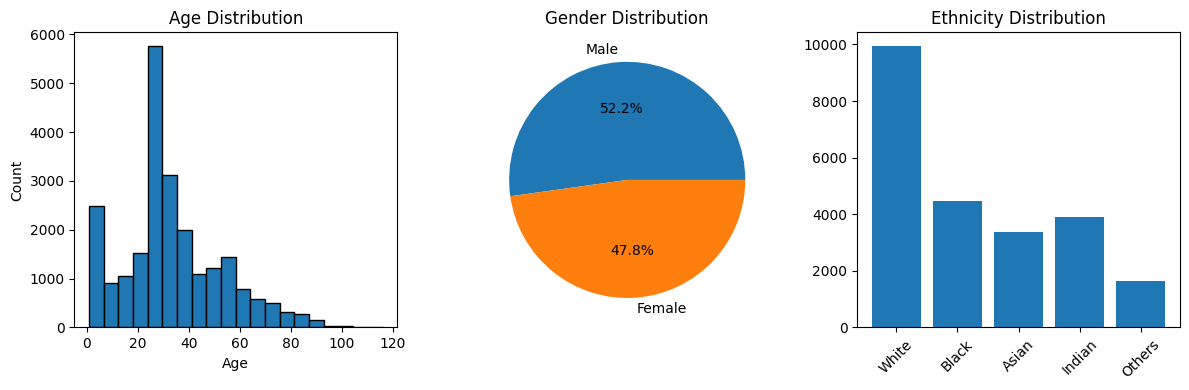

In [6]:
# Age distribution histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(df['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Gender pie
plt.subplot(1, 3, 2)
gender_counts = df['gender'].value_counts()
plt.pie(gender_counts.values, labels=['Male', 'Female'], autopct='%1.1f%%')
plt.title('Gender Distribution')

# Ethnicity bar
plt.subplot(1, 3, 3)
race_counts = df['race'].value_counts().sort_index()
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']
plt.bar(race_labels, race_counts.values)
plt.title('Ethnicity Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Install Git
!apt-get install git

# Configure Git (replace with your details)
!git config --global user.email "trivikramants@gmail.com"
!git config --global user.name "Trivikraman-TS"

# Clone your repository
!git clone https://github.com/Trivikraman-TS/Futura_Face.git
%cd Futura_Face

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Cloning into 'Futura_Face'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.
/content/Futura_Face


In [8]:
%cd /content/Futura_Face
!pwd

/content/Futura_Face
/content/Futura_Face


In [10]:
# Move the notebook
!cp /content/futura_face_preprocessing.ipynb .

cp: cannot stat '/content/futura_face_preprocessing.ipynb': No such file or directory
